In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collection_library_utils import build_collection_library
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
from utils import params
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
occu_recon = pred['occupancy_recon']
flow_recon = pred['flow_recon']
speed_recon = pred['speed_recon']

k_t = pred['k_t'].to(torch.device('cpu'))
k_x = pred['k_x'].to(torch.device('cpu'))
q_x = pred['q_x'].to(torch.device('cpu'))
v_x = pred['v_x'].to(torch.device('cpu'))
k_xx = pred['k_xx'].to(torch.device('cpu'))
q_xx = pred['q_xx'].to(torch.device('cpu'))
v_xx = pred['v_xx'].to(torch.device('cpu'))

coeff = pred[('coefficients')].to(torch.device('cpu'))

### 2 mins prediction

In [5]:
z = torch.cat((occu_recon, flow_recon, speed_recon, k_x, q_x, v_x, k_xx, q_xx, v_xx), dim=1)
Theta = build_collection_library(z, poly_order=params['poly_order'], include_sine=False)
k_t_predict = torch.matmul(Theta, coeff)

In [6]:
occu_1 = occu_recon + k_t_predict

In [7]:
pred_occu_recon = torch.cat((X_occu_all, occu_recon), dim=1).detach().numpy()
pred_occu_recon = pd.DataFrame(pred_occu_recon, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_recon['TimeStep'] = pred_occu_recon['TimeStep'].astype(int)
pred_occu_recon['Station_Number'] = pred_occu_recon['Station_Number'].astype(int)
pred_occu_recon = pred_occu_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

In [8]:
pred_occu_1 = torch.cat((X_occu_all, occu_1), dim=1).detach().numpy()
pred_occu_1 = pd.DataFrame(pred_occu_1, columns = ['TimeStep','Station_Number','Occupancy'])
pred_occu_1['TimeStep'] = pred_occu_1['TimeStep'].astype(int)
pred_occu_1['Station_Number'] = pred_occu_1['Station_Number'].astype(int)
pred_occu_1 = pred_occu_1.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')

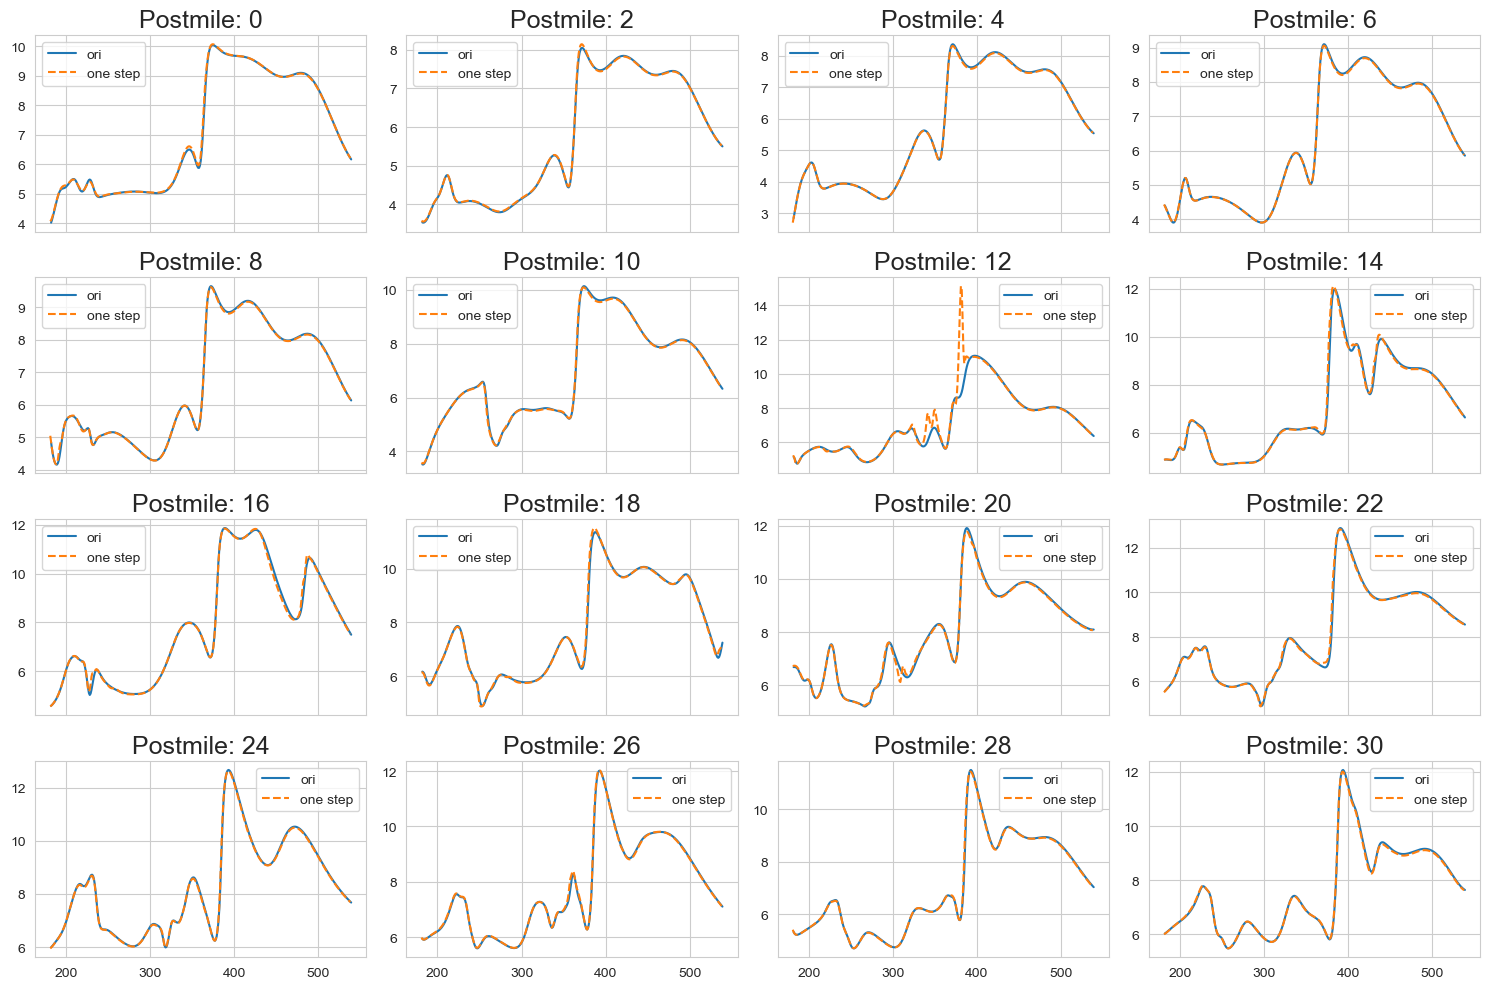

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharex=True)
axes = axes.flatten()
# Plotting the data for each row in both dataframes
for i in range(16):
    axes[i].plot(pred_occu_recon.iloc[i, 1:], label='ori')
    axes[i].plot(pred_occu_1.iloc[i, :-1], linestyle = '--', label='one step')
    axes[i].set_title(f'Postmile: {i * 2}', fontsize = 18)
    # axes[i].set_ylim(-0.6, 0.8)
    axes[i].legend()
plt.tight_layout()

In [20]:
pred_occu_recon.iloc[:, 1:]

TimeStep,182,183,184,185,186,187,188,189,190,191,...,530,531,532,533,534,535,536,537,538,539
Station_Number,,,,,,,,,,,,,,,,,,,,,
0,4.012838,4.101165,4.206514,4.321679,4.441659,4.562648,4.681261,4.794007,4.897038,4.986252,...,6.617268,6.559903,6.503977,6.449525,6.396664,6.345449,6.295964,6.248282,6.202492,6.158675
1,3.531239,3.525821,3.530097,3.543551,3.565653,3.595814,3.633330,3.677323,3.726670,3.779949,...,5.751828,5.718267,5.685899,5.654784,5.624981,5.596566,5.569619,5.544218,5.520455,5.498438
2,2.844725,2.998957,3.152370,3.301796,3.444674,3.579114,3.703780,3.817724,3.920314,4.011362,...,5.809374,5.773484,5.738907,5.705709,5.673945,5.643691,5.615021,5.588006,5.562747,5.539339
3,4.396887,4.342671,4.285328,4.225348,4.163708,4.101989,4.042483,3.988227,3.942954,3.910896,...,6.188953,6.145342,6.103075,6.062218,6.022849,5.985046,5.948880,5.914432,5.881790,5.851036
4,4.839543,4.647595,4.483245,4.351985,4.255198,4.191616,4.159797,4.160526,4.197921,4.278138,...,6.532944,6.483330,6.434732,6.387249,6.340963,6.295956,6.252316,6.210129,6.169465,6.130422
5,3.517741,3.512146,3.534873,3.581464,3.646616,3.725009,3.811918,3.903514,3.996946,4.090179,...,6.758200,6.706987,6.656343,6.606370,6.557134,6.508723,6.461223,6.414685,6.369205,6.324840
6,5.158849,5.076899,4.942101,4.818006,4.759664,4.775572,4.843541,4.936375,5.032574,5.118701,...,6.788040,6.740005,6.692320,6.645066,6.598300,6.552083,6.506475,6.461512,6.417268,6.373772
7,4.891356,4.894533,4.893749,4.889901,4.884196,4.877995,4.872763,4.870081,4.871760,4.880035,...,7.088253,7.037097,6.986351,6.936065,6.886286,6.837058,6.788418,6.740402,6.693048,6.646375
8,4.579815,4.611556,4.648602,4.690820,4.738267,4.791155,4.849827,4.914745,4.986468,5.065601,...,8.033889,7.970900,7.908539,7.846854,7.785880,7.725661,7.666233,7.607620,7.549855,7.492963


In [21]:
pred_occu_1.iloc[:, :-1]

TimeStep,181,182,183,184,185,186,187,188,189,190,...,529,530,531,532,533,534,535,536,537,538
Station_Number,,,,,,,,,,,,,,,,,,,,,
0,4.060087,4.098176,4.168830,4.261362,4.367375,4.480586,4.596140,4.709950,4.818259,4.917576,...,6.676007,6.617341,6.559985,6.504032,6.449518,6.396562,6.345220,6.295576,6.247703,6.201693
1,3.576203,3.559887,3.553722,3.557155,3.569637,3.590616,3.619493,3.655573,3.697998,3.745684,...,5.783332,5.748885,5.715558,5.683412,5.652507,5.622903,5.594673,5.567899,5.542658,5.519044
2,2.702124,2.852766,3.006062,3.158563,3.307125,3.449197,3.582899,3.706897,3.820244,3.922306,...,5.836139,5.799299,5.763713,5.729434,5.696524,5.665040,5.635057,5.606649,5.579885,5.554868
3,4.426251,4.376903,4.324743,4.269763,4.212325,4.153337,4.094378,4.037799,3.986747,3.945078,...,6.219882,6.175352,6.132085,6.090159,6.049640,6.010603,5.973126,5.937280,5.903142,5.870804
4,5.044608,4.839997,4.653985,4.489552,4.355267,4.255911,4.193074,4.171022,4.203106,4.310125,...,6.568069,6.517900,6.468660,6.420436,6.373325,6.327411,6.282772,6.239497,6.197669,6.157359
5,3.586668,3.558113,3.552121,3.571726,3.614210,3.674874,3.748838,3.831716,3.919856,4.010423,...,6.793896,6.742548,6.691675,6.641373,6.591741,6.542846,6.494776,6.447617,6.401418,6.356274
6,5.185551,5.201917,5.089889,4.826721,4.707007,4.734235,4.780396,4.848547,4.938065,5.032068,...,6.821072,6.773102,6.725414,6.678074,6.631162,6.584736,6.538855,6.493582,6.448949,6.405035
7,4.882604,4.891811,4.897257,4.899115,4.897910,4.894475,4.889871,4.885354,4.882397,4.882840,...,7.116762,7.065659,7.014895,6.964540,6.914641,6.865246,6.816399,6.768138,6.720497,6.673515
8,4.552151,4.579230,4.612080,4.650327,4.693797,4.742480,4.796512,4.856162,4.921834,4.994047,...,8.058583,7.995492,7.932999,7.871139,7.809960,7.749495,7.689788,7.630875,7.572780,7.515533


In [10]:
mean_squared_error = np.nanmean((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) ** 2)
rmse_occu_1 = np.sqrt(mean_squared_error)
rmse_occu_1

0.17913193315051892

mape_occu_1 = np.nanmean(np.abs((pred_occu_recon.iloc[:,1:].values - pred_occu_1.iloc[:,:-1].values) / pred_occu_recon.iloc[:,1:].values)) * 100
mape_occu_1

### 4 mins preditction

In [18]:
pred_occu_1

TimeStep,181,182,183,184,185,186,187,188,189,190,...,530,531,532,533,534,535,536,537,538,539
Station_Number,,,,,,,,,,,,,,,,,,,,,
0,4.060087,4.098176,4.168830,4.261362,4.367375,4.480586,4.596140,4.709950,4.818259,4.917576,...,6.617341,6.559985,6.504032,6.449518,6.396562,6.345220,6.295576,6.247703,6.201693,6.157623
1,3.576203,3.559887,3.553722,3.557155,3.569637,3.590616,3.619493,3.655573,3.697998,3.745684,...,5.748885,5.715558,5.683412,5.652507,5.622903,5.594673,5.567899,5.542658,5.519044,5.497162
2,2.702124,2.852766,3.006062,3.158563,3.307125,3.449197,3.582899,3.706897,3.820244,3.922306,...,5.799299,5.763713,5.729434,5.696524,5.665040,5.635057,5.606649,5.579885,5.554868,5.531692
3,4.426251,4.376903,4.324743,4.269763,4.212325,4.153337,4.094378,4.037799,3.986747,3.945078,...,6.175352,6.132085,6.090159,6.049640,6.010603,5.973126,5.937280,5.903142,5.870804,5.840343
4,5.044608,4.839997,4.653985,4.489552,4.355267,4.255911,4.193074,4.171022,4.203106,4.310125,...,6.517900,6.468660,6.420436,6.373325,6.327411,6.282772,6.239497,6.197669,6.157359,6.118664
5,3.586668,3.558113,3.552121,3.571726,3.614210,3.674874,3.748838,3.831716,3.919856,4.010423,...,6.742548,6.691675,6.641373,6.591741,6.542846,6.494776,6.447617,6.401418,6.356274,6.312244
6,5.185551,5.201917,5.089889,4.826721,4.707007,4.734235,4.780396,4.848547,4.938065,5.032068,...,6.773102,6.725414,6.678074,6.631162,6.584736,6.538855,6.493582,6.448949,6.405035,6.361865
7,4.882604,4.891811,4.897257,4.899115,4.897910,4.894475,4.889871,4.885354,4.882397,4.882840,...,7.065659,7.014895,6.964540,6.914641,6.865246,6.816399,6.768138,6.720497,6.673515,6.627212
8,4.552151,4.579230,4.612080,4.650327,4.693797,4.742480,4.796512,4.856162,4.921834,4.994047,...,7.995492,7.932999,7.871139,7.809960,7.749495,7.689788,7.630875,7.572780,7.515533,7.459162


### 6 mins prediction